# E-Commerce Data 머신러닝 분석

## 데이터셋 정보
- **출처**: Kaggle (https://www.kaggle.com/datasets/carrie1/ecommerce-data)
- **원본**: UCI Machine Learning Repository
- **기간**: 2010년 12월 1일 ~ 2011년 12월 9일
- **업체**: 영국 기반 온라인 소매업체 (선물용품 판매)

## 분석 목표
1. 고객 세분화 (Customer Segmentation) - 클러스터링
2. 매출 예측 (Sales Prediction) - 회귀 분석

## 1. 데이터 로드 및 기본 정보 확인

In [2]:
# 필요한 라이브러리 설치 (Colab 환경)
# !pip install kagglehub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style('whitegrid')

# 이미지 저장 폴더 생성
IMG_DIR = 'images'
os.makedirs(IMG_DIR, exist_ok=True)

def save_fig(filename):
    """그래프를 이미지 파일로 저장하는 함수"""
    plt.savefig(f'{IMG_DIR}/{filename}', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"저장 완료: {IMG_DIR}/{filename}")

print("라이브러리 로드 완료")
print(f"이미지 저장 폴더: {IMG_DIR}/")

라이브러리 로드 완료
이미지 저장 폴더: images/


In [3]:
# 데이터 로드 (Kaggle에서 다운로드 후 업로드하거나 kagglehub 사용)
# 방법 1: 로컬 파일 사용
# df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# 방법 2: Kaggle API 사용
import kagglehub
path = kagglehub.dataset_download("carrie1/ecommerce-data")
print("데이터셋 경로:", path)

import os
for file in os.listdir(path):
    print(f"파일: {file}")

# 데이터 로드
df = pd.read_csv(f"{path}/data.csv", encoding='ISO-8859-1')
print(f"\n데이터 로드 완료: {df.shape[0]:,}행 x {df.shape[1]}열")

데이터셋 경로: /Users/gamjar/.cache/kagglehub/datasets/carrie1/ecommerce-data/versions/1
파일: data.csv

데이터 로드 완료: 541,909행 x 8열


In [4]:
# 데이터 기본 정보 확인
print("=" * 50)
print("데이터 기본 정보")
print("=" * 50)
df.info()

데이터 기본 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# 상위 5개 행 확인
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# 기술통계량 확인
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# 결측치 확인
print("=" * 50)
print("결측치 현황")
print("=" * 50)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'결측치 수': missing, '비율(%)': missing_pct})
print(missing_df[missing_df['결측치 수'] > 0])

결측치 현황
              결측치 수  비율(%)
Description    1454   0.27
CustomerID   135080  24.93


## 2. 데이터 전처리

In [8]:
# 원본 데이터 복사
df_clean = df.copy()

# CustomerID 결측치 제거 (고객 분석에 필수)
df_clean = df_clean.dropna(subset=['CustomerID'])
print(f"CustomerID 결측치 제거 후: {len(df_clean):,}행")

# CustomerID를 정수형으로 변환
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# 취소 주문 제거 (InvoiceNo가 'C'로 시작하는 경우)
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"취소 주문 제거 후: {len(df_clean):,}행")

# 수량과 가격이 0 이하인 데이터 제거
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"비정상 데이터 제거 후: {len(df_clean):,}행")

CustomerID 결측치 제거 후: 406,829행
취소 주문 제거 후: 397,924행
비정상 데이터 제거 후: 397,884행


In [9]:
# 날짜 변환
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 총 매출액 컬럼 생성
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 날짜 관련 피처 추출
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['Day'] = df_clean['InvoiceDate'].dt.day
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

print("전처리 완료!")
df_clean.head()

전처리 완료!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,DayOfWeek,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8


저장 완료: images/01_boxplot_outliers.png


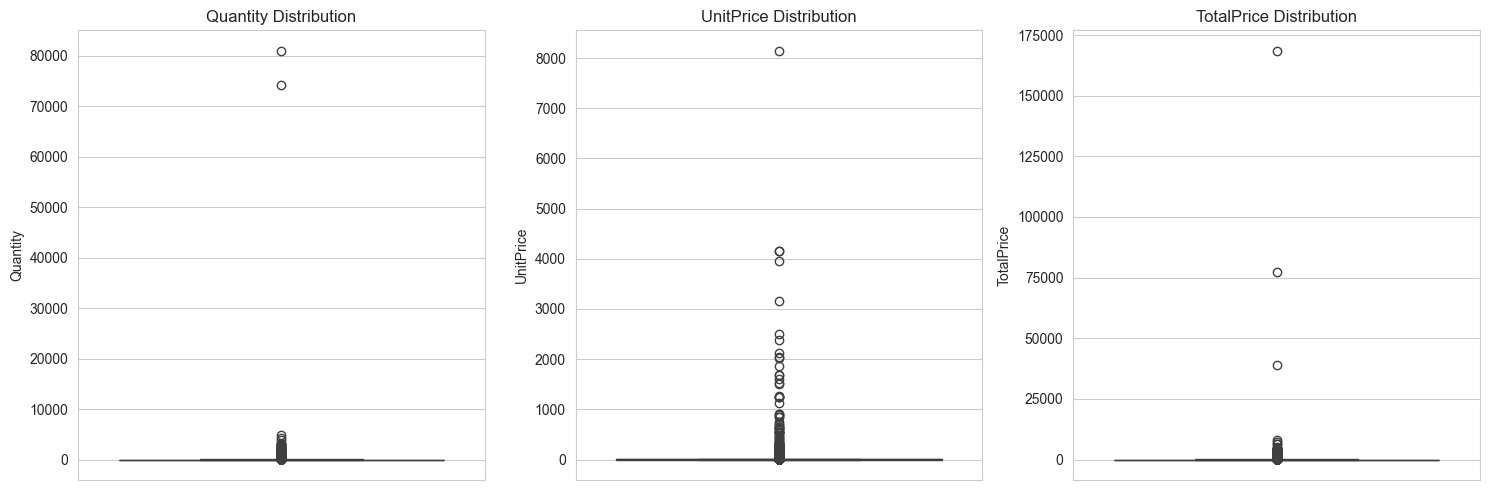

In [10]:
# 이상치 확인 (박스플롯)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(y=df_clean['Quantity'], ax=axes[0])
axes[0].set_title('Quantity Distribution')

sns.boxplot(y=df_clean['UnitPrice'], ax=axes[1])
axes[1].set_title('UnitPrice Distribution')

sns.boxplot(y=df_clean['TotalPrice'], ax=axes[2])
axes[2].set_title('TotalPrice Distribution')

plt.tight_layout()
save_fig('01_boxplot_outliers.png')
plt.show()

In [11]:
# 이상치 제거 (IQR 방식)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_clean = remove_outliers(df_clean, 'Quantity')
df_clean = remove_outliers(df_clean, 'UnitPrice')
df_clean = remove_outliers(df_clean, 'TotalPrice')

print(f"이상치 제거 후: {len(df_clean):,}행")

이상치 제거 후: 324,716행


## 3. 탐색적 데이터 분석 (EDA)

저장 완료: images/02_country_sales.png


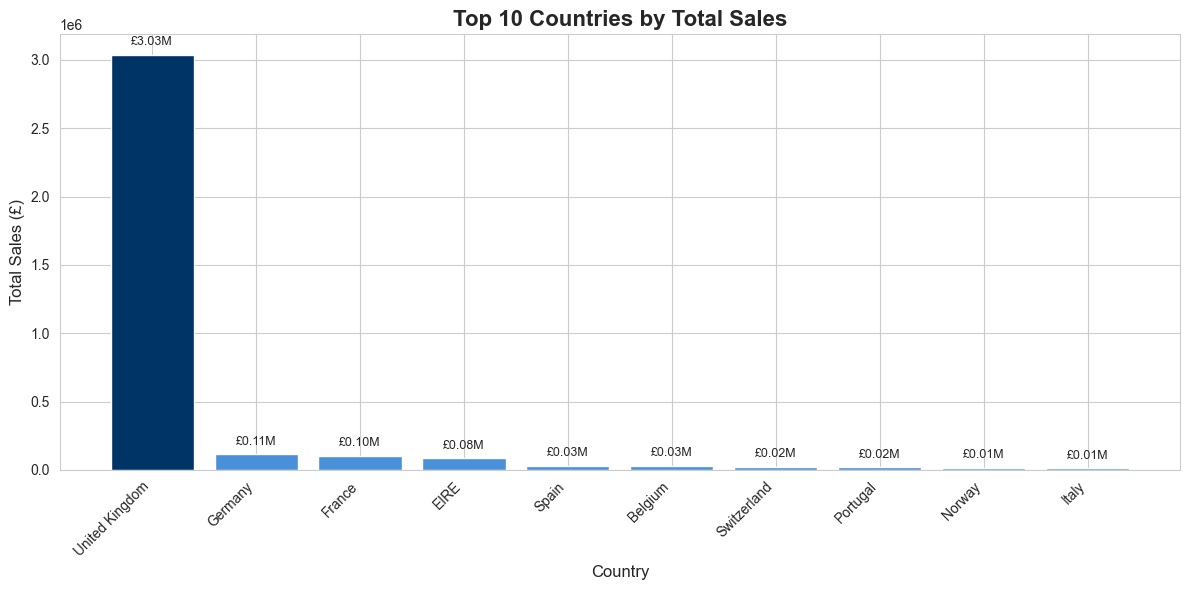


Top 10 국가별 매출:
Country
United Kingdom    3034818.084
Germany            113053.470
France             101985.210
EIRE                83573.730
Spain               27089.100
Belgium             26066.740
Switzerland         22467.500
Portugal            17439.110
Norway              11755.570
Italy               10165.660
Name: TotalPrice, dtype: float64


In [12]:
# 국가별 매출 분석
country_sales = df_clean.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = ['#003366' if i == 0 else '#4a90d9' for i in range(10)]
bars = plt.bar(country_sales.head(10).index, country_sales.head(10).values, color=colors, edgecolor='white')
plt.title('Top 10 Countries by Total Sales', fontsize=16, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Sales (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 값 표시
for bar, val in zip(bars, country_sales.head(10).values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50000, 
             f'£{val/1000000:.2f}M', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
save_fig('02_country_sales.png')
plt.show()

print("\nTop 10 국가별 매출:")
print(country_sales.head(10))

저장 완료: images/03_monthly_sales.png


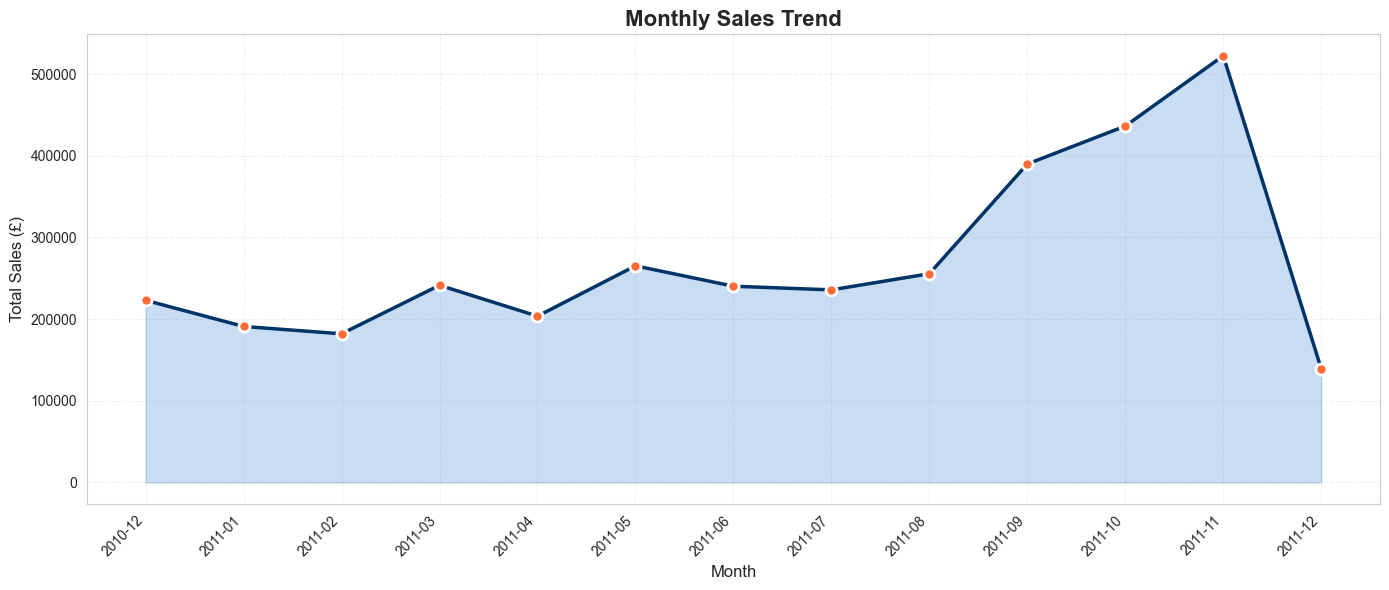

In [13]:
# 월별 매출 추이
monthly_sales = df_clean.groupby(['Year', 'Month'])['TotalPrice'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['TotalPrice'], marker='o', linewidth=2.5, 
         color='#003366', markersize=8, markerfacecolor='#ff6b35', markeredgecolor='white', markeredgewidth=2)
plt.fill_between(monthly_sales['YearMonth'], monthly_sales['TotalPrice'], alpha=0.3, color='#4a90d9')
plt.title('Monthly Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales (£)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_fig('03_monthly_sales.png')
plt.show()

저장 완료: images/04_daily_sales.png


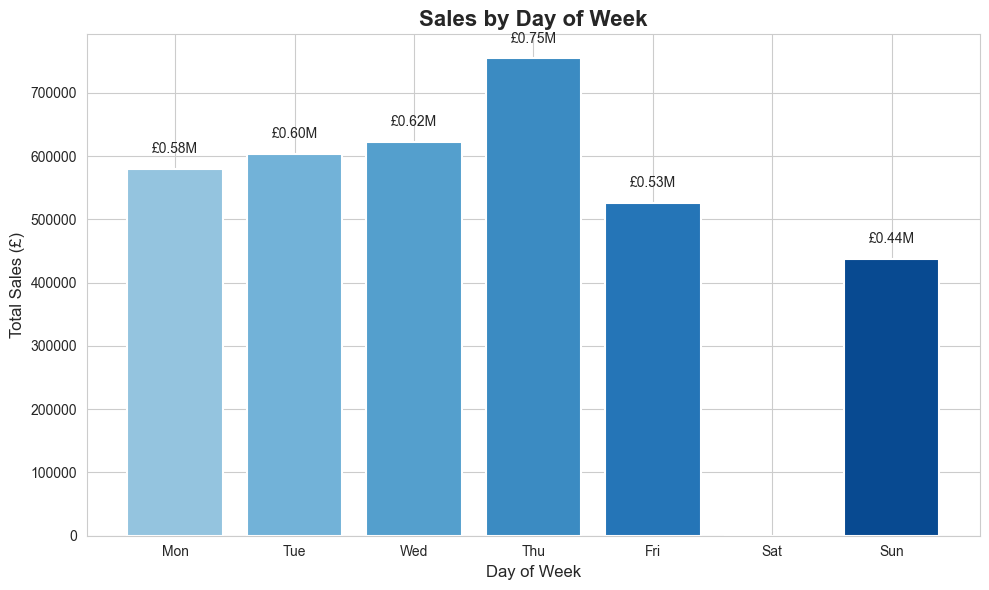

In [14]:
# 요일별 매출 분석
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_sales_by_dow = df_clean.groupby('DayOfWeek')['TotalPrice'].sum().reindex(range(7), fill_value=0)

plt.figure(figsize=(10, 6))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, 7))
bars = plt.bar(day_names, daily_sales_by_dow.values, color=colors, edgecolor='white', linewidth=1.5)
plt.title('Sales by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales (£)', fontsize=12)

# 값 표시
for bar, val in zip(bars, daily_sales_by_dow.values):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000, 
                 f'£{val/1000000:.2f}M', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
save_fig('04_daily_sales.png')
plt.show()

저장 완료: images/05_hourly_transactions.png


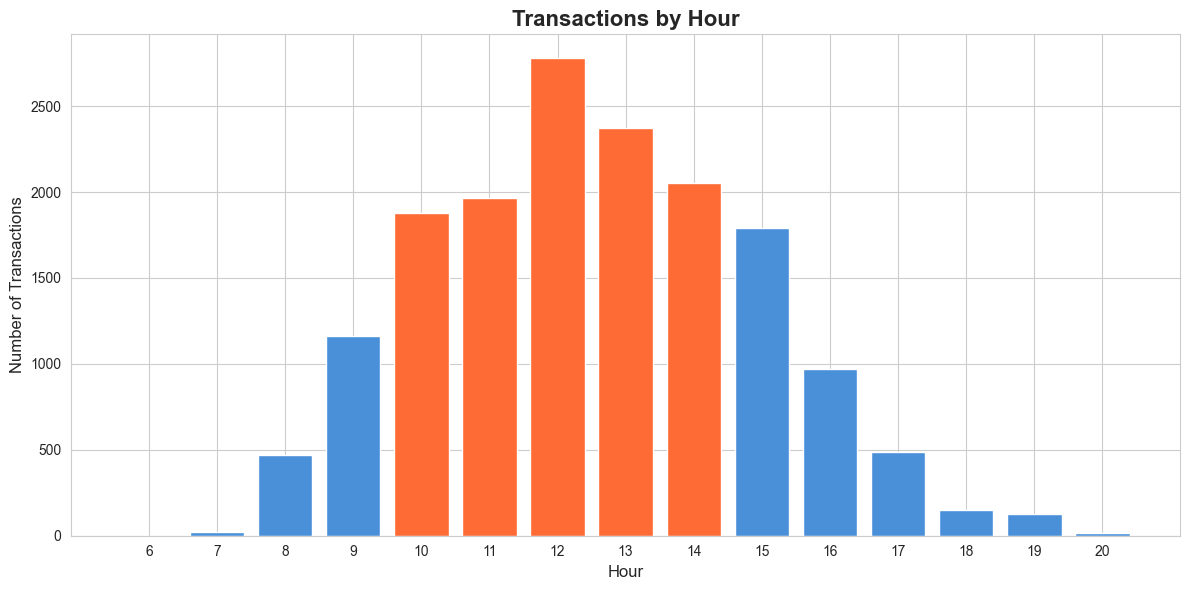

In [15]:
# 시간대별 거래 건수
hourly_transactions = df_clean.groupby('Hour')['InvoiceNo'].nunique()

plt.figure(figsize=(12, 6))
colors = ['#ff6b35' if h in [10, 11, 12, 13, 14] else '#4a90d9' for h in hourly_transactions.index]
bars = plt.bar(hourly_transactions.index, hourly_transactions.values, color=colors, edgecolor='white')
plt.title('Transactions by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(hourly_transactions.index)
plt.tight_layout()
save_fig('05_hourly_transactions.png')
plt.show()

저장 완료: images/06_top_products.png


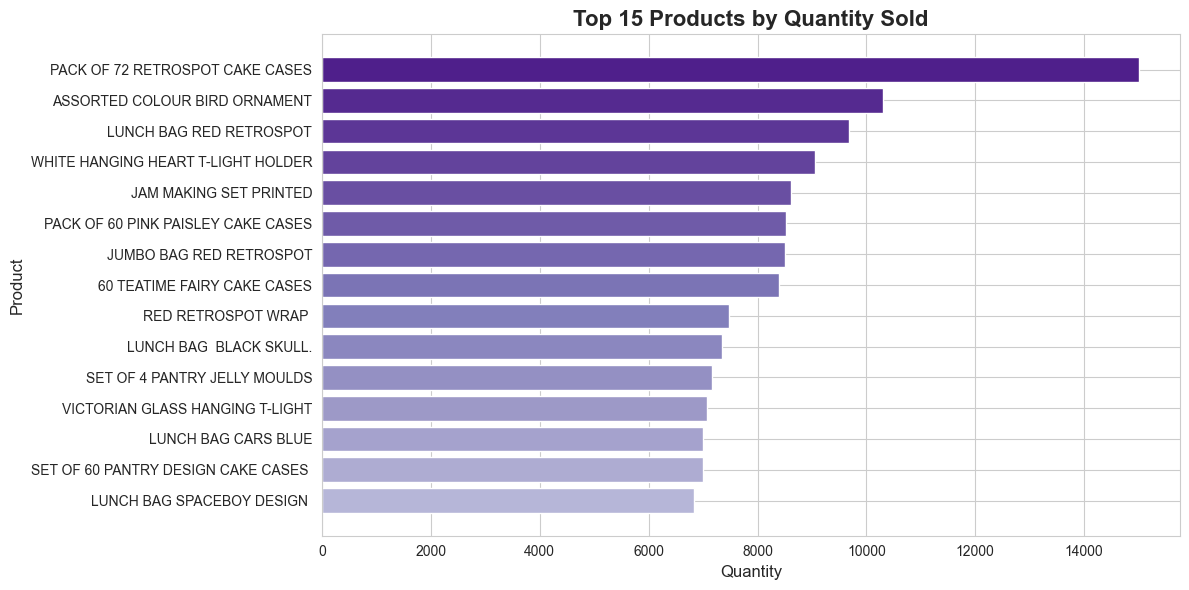

In [16]:
# 상위 판매 상품
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(top_products)))[::-1]
bars = plt.barh(top_products.index, top_products.values, color=colors, edgecolor='white')
plt.title('Top 15 Products by Quantity Sold', fontsize=16, fontweight='bold')
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
save_fig('06_top_products.png')
plt.show()

저장 완료: images/07_correlation_heatmap.png


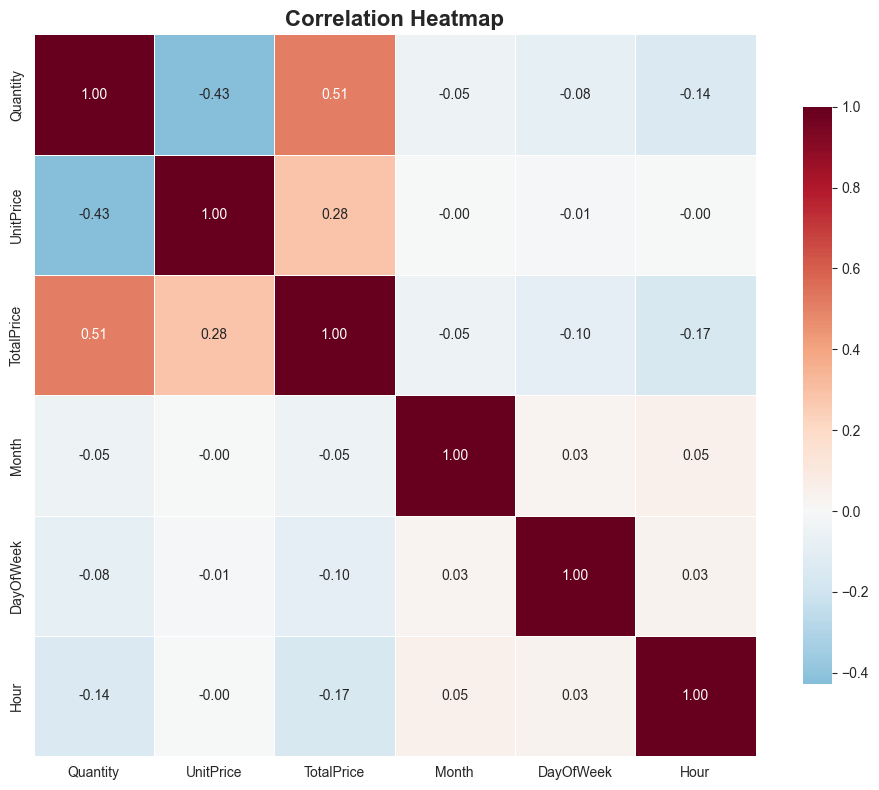

In [17]:
# 상관관계 히트맵
numeric_cols = df_clean[['Quantity', 'UnitPrice', 'TotalPrice', 'Month', 'DayOfWeek', 'Hour']]
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5,
            center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
save_fig('07_correlation_heatmap.png')
plt.show()

## 4. 고객 세분화 (RFM 분석 + 클러스터링)

In [18]:
# RFM 분석을 위한 데이터 준비
# R (Recency): 최근 구매일로부터 경과 일수
# F (Frequency): 구매 빈도
# M (Monetary): 총 구매 금액

snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print(f"기준일: {snapshot_date}")

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(f"\nRFM 데이터: {len(rfm)}명의 고객")
rfm.head(10)

기준일: 2011-12-10 12:50:00

RFM 데이터: 4146명의 고객


,CustomerID,Recency,Frequency,Monetary
0,12347,2,7,2783.37
1,12348,249,3,90.20
2,12349,19,1,939.75
3,12350,310,1,294.40
4,12352,36,7,1130.94
5,12353,204,1,29.30
6,12354,232,1,642.13
7,12355,214,1,179.40
8,12356,246,2,491.06
9,12357,33,1,1289.35


저장 완료: images/08_rfm_distribution.png


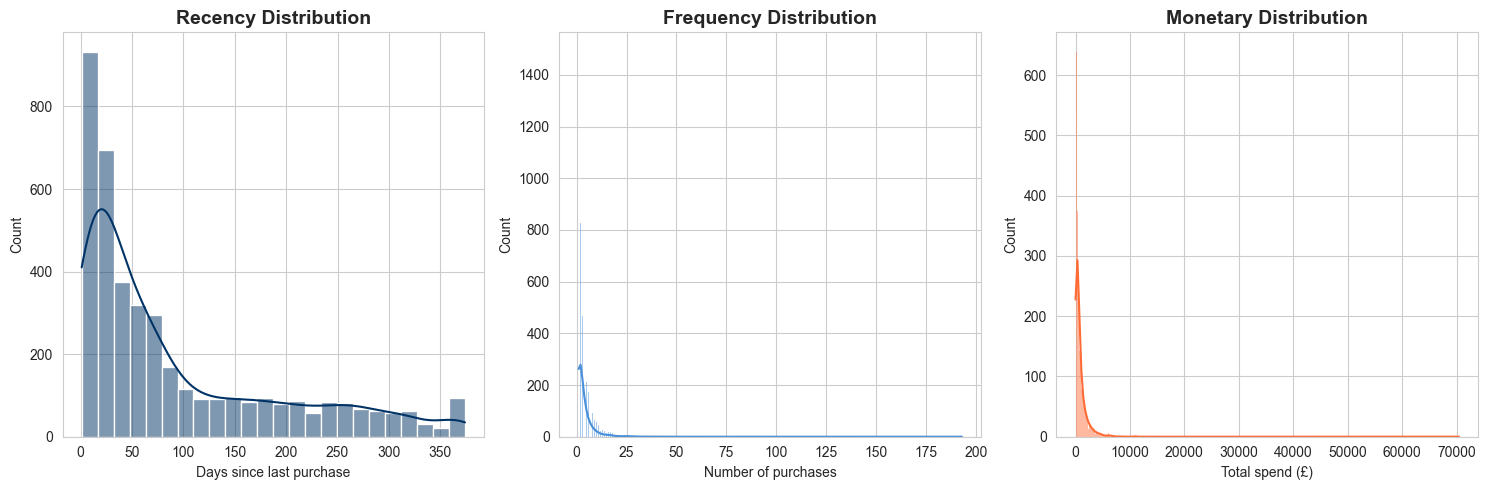

In [19]:
# RFM 분포 확인
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#003366', '#4a90d9', '#ff6b35']

sns.histplot(rfm['Recency'], kde=True, ax=axes[0], color=colors[0])
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days since last purchase')

sns.histplot(rfm['Frequency'], kde=True, ax=axes[1], color=colors[1])
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of purchases')

sns.histplot(rfm['Monetary'], kde=True, ax=axes[2], color=colors[2])
axes[2].set_title('Monetary Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total spend (£)')

plt.tight_layout()
save_fig('08_rfm_distribution.png')
plt.show()

In [20]:
# 로그 변환 (왜도 감소)
rfm_log = rfm.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("스케일링 완료")
rfm_scaled.describe()

스케일링 완료


,Recency,Frequency,Monetary
count,4.146000e+03,4.146000e+03,4146.000000
mean,-2.313634e-17,3.967454e-16,0.000000
std,1.000121e+00,1.000121e+00,1.000121
min,-2.370748e+00,-9.428830e-01,-3.988399
25%,-6.786958e-01,-9.428830e-01,-0.664552
50%,7.801043e-02,-3.216185e-01,0.007393
75%,8.539259e-01,4.610823e-01,0.696474
max,1.562917e+00,6.066612e+00,4.114399


저장 완료: images/09_elbow_method.png


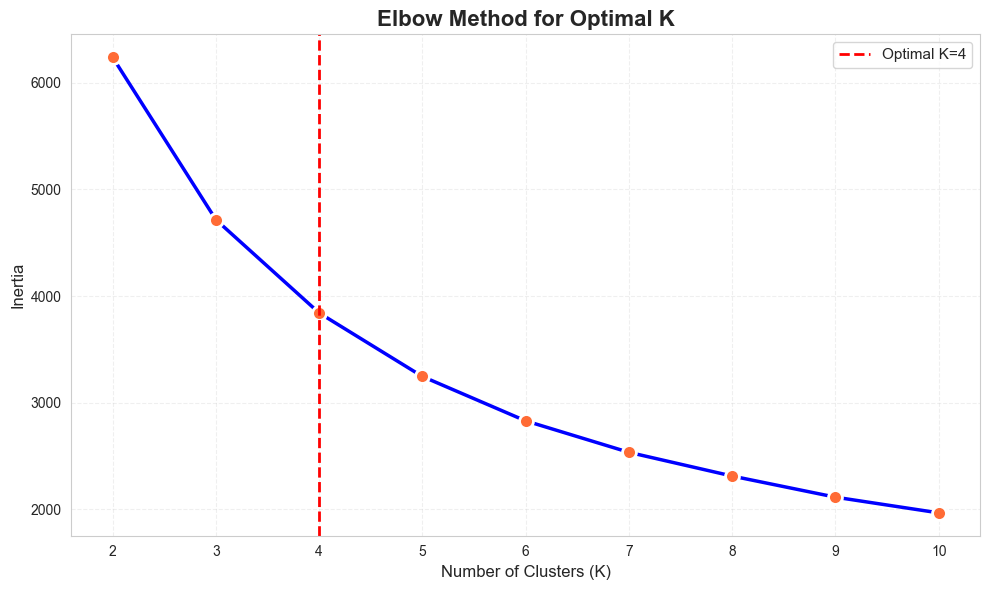

In [21]:
# 최적의 클러스터 수 찾기 (Elbow Method)
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2.5, markersize=10, 
         markerfacecolor='#ff6b35', markeredgecolor='white', markeredgewidth=2)
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label='Optimal K=4')
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_fig('09_elbow_method.png')
plt.show()

K=2: Silhouette Score = 0.4252
K=3: Silhouette Score = 0.3241
K=4: Silhouette Score = 0.3260
K=5: Silhouette Score = 0.2895
K=6: Silhouette Score = 0.2910
K=7: Silhouette Score = 0.2861
K=8: Silhouette Score = 0.2842
K=9: Silhouette Score = 0.2890
K=10: Silhouette Score = 0.2815
저장 완료: images/10_silhouette_score.png


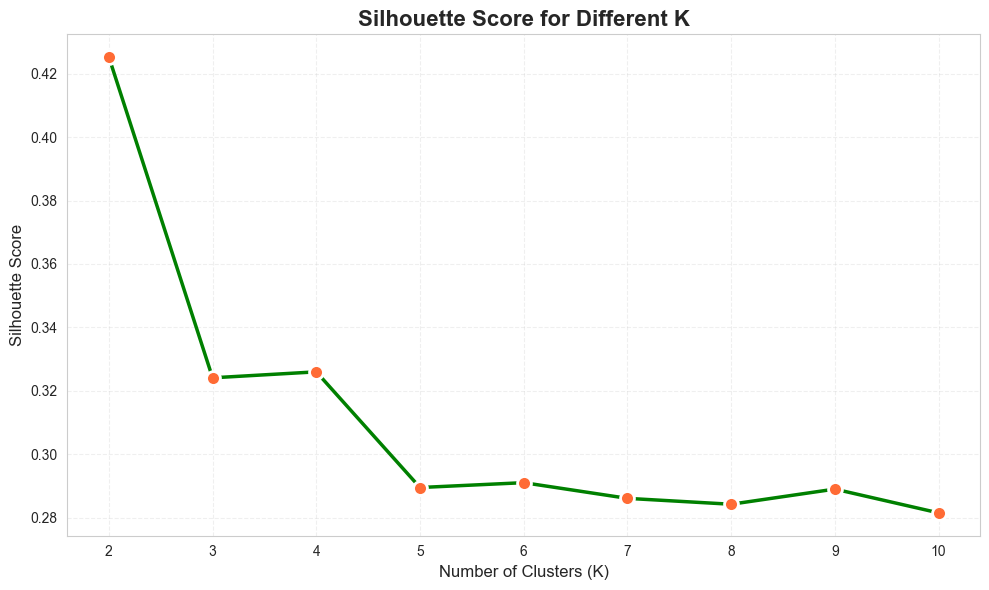

In [22]:
# Silhouette Score로 최적 K 확인
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}: Silhouette Score = {score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2.5, markersize=10,
         markerfacecolor='#ff6b35', markeredgecolor='white', markeredgewidth=2)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Different K', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
save_fig('10_silhouette_score.png')
plt.show()

In [23]:
# K-Means 클러스터링 (K=4 선택)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(f"클러스터링 완료 (K={optimal_k})")
print("\n클러스터별 고객 수:")
print(rfm['Cluster'].value_counts().sort_index())

클러스터링 완료 (K=4)

클러스터별 고객 수:
Cluster
0     745
1     826
2    1465
3    1110
Name: count, dtype: int64


In [24]:
# 클러스터별 RFM 평균
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)
cluster_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

print("클러스터별 RFM 요약:")
cluster_summary

클러스터별 RFM 요약:


,Avg_Recency,Avg_Frequency,Avg_Monetary,Customer_Count
Cluster,,,,
0,12.94,11.60,2635.84,745
1,21.25,1.93,313.99,826
2,189.73,1.27,190.44,1465
3,73.14,3.73,921.15,1110


저장 완료: images/11_cluster_visualization.png


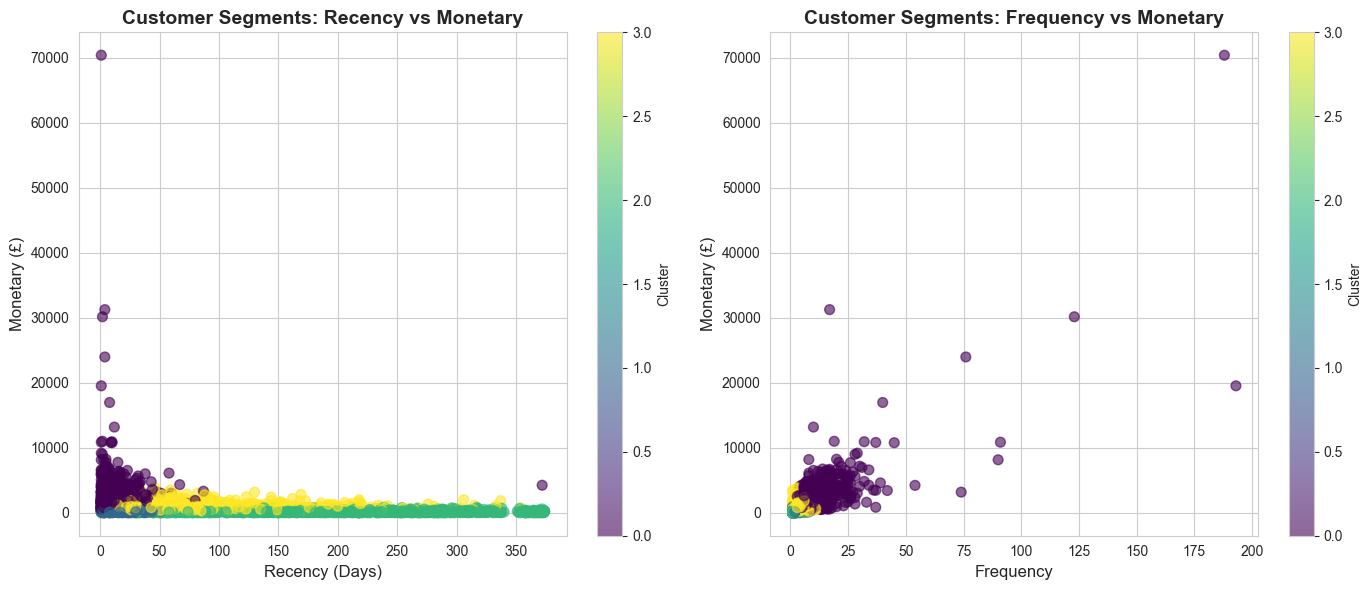

In [25]:
# 클러스터 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Recency vs Monetary
scatter1 = axes[0].scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel('Recency (Days)', fontsize=12)
axes[0].set_ylabel('Monetary (£)', fontsize=12)
axes[0].set_title('Customer Segments: Recency vs Monetary', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Frequency vs Monetary
scatter2 = axes[1].scatter(rfm['Frequency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', alpha=0.6, s=50)
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_ylabel('Monetary (£)', fontsize=12)
axes[1].set_title('Customer Segments: Frequency vs Monetary', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
save_fig('11_cluster_visualization.png')
plt.show()

저장 완료: images/12_cluster_rfm_avg.png


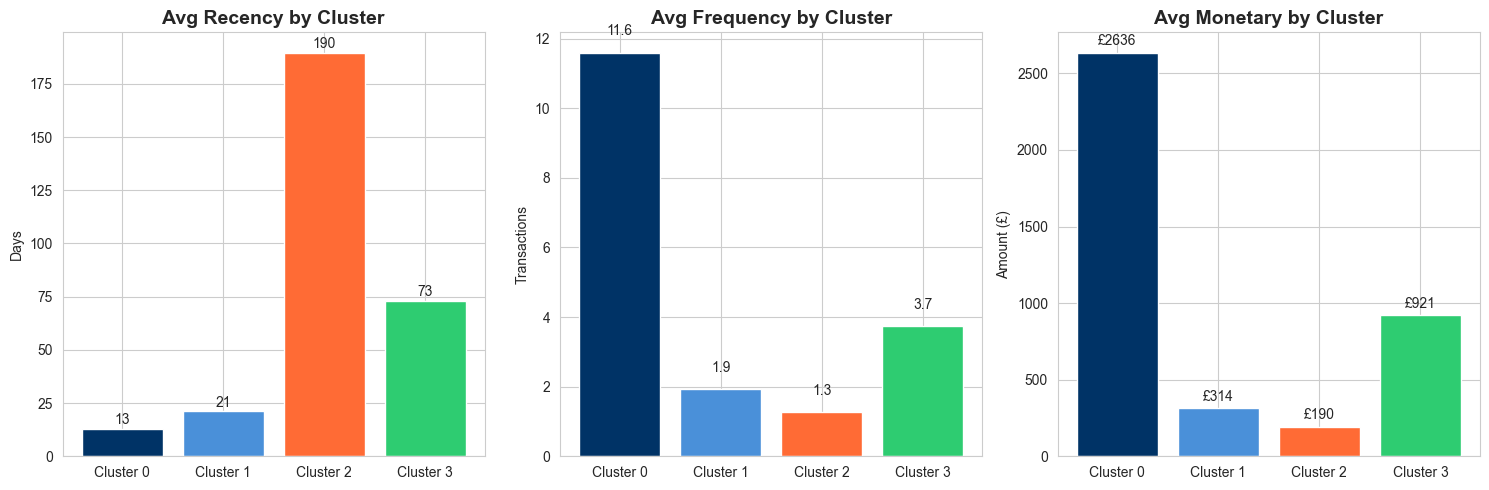

In [26]:
# 클러스터별 RFM 평균 막대 그래프
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cluster_labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
colors = ['#003366', '#4a90d9', '#ff6b35', '#2ecc71']

bars1 = axes[0].bar(cluster_labels, cluster_summary['Avg_Recency'].values, color=colors, edgecolor='white')
axes[0].set_title('Avg Recency by Cluster', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Days')
for bar, val in zip(bars1, cluster_summary['Avg_Recency'].values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}', ha='center', fontsize=10)

bars2 = axes[1].bar(cluster_labels, cluster_summary['Avg_Frequency'].values, color=colors, edgecolor='white')
axes[1].set_title('Avg Frequency by Cluster', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Transactions')
for bar, val in zip(bars2, cluster_summary['Avg_Frequency'].values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=10)

bars3 = axes[2].bar(cluster_labels, cluster_summary['Avg_Monetary'].values, color=colors, edgecolor='white')
axes[2].set_title('Avg Monetary by Cluster', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Amount (£)')
for bar, val in zip(bars3, cluster_summary['Avg_Monetary'].values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'£{val:.0f}', ha='center', fontsize=10)

plt.tight_layout()
save_fig('12_cluster_rfm_avg.png')
plt.show()

## 5. 매출 예측 모델링 (회귀 분석)

In [27]:
# 일별 매출 데이터 생성
daily_sales = df_clean.groupby(df_clean['InvoiceDate'].dt.date).agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique'
}).reset_index()

daily_sales.columns = ['Date', 'TotalSales', 'TotalQuantity', 'NumTransactions', 'NumCustomers']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

# 시간 특성 추가
daily_sales['DayOfWeek'] = daily_sales['Date'].dt.dayofweek
daily_sales['Month'] = daily_sales['Date'].dt.month
daily_sales['Day'] = daily_sales['Date'].dt.day
daily_sales['WeekOfYear'] = daily_sales['Date'].dt.isocalendar().week

print(f"일별 매출 데이터: {len(daily_sales)}일")
daily_sales.head(10)

일별 매출 데이터: 305일


,Date,TotalSales,TotalQuantity,NumTransactions,NumCustomers,DayOfWeek,Month,Day,WeekOfYear
0,2010-12-01,16229.66,9409,102,83,2,12,1,48
1,2010-12-02,18952.10,11208,117,87,3,12,2,48
2,2010-12-03,8888.39,5309,46,41,4,12,3,48
3,2010-12-05,17686.70,9967,81,71,6,12,5,48
4,2010-12-06,14543.31,8376,88,78,0,12,6,49
5,2010-12-07,10838.85,5818,57,56,1,12,7,49
6,2010-12-08,17824.17,10800,94,85,2,12,8,49
7,2010-12-09,15039.19,8513,85,80,3,12,9,49
8,2010-12-10,11758.06,6763,63,49,4,12,10,49
9,2010-12-12,8993.98,4779,39,38,6,12,12,49


In [28]:
# 특성(X)과 타겟(y) 설정
features = ['TotalQuantity', 'NumTransactions', 'NumCustomers', 'DayOfWeek', 'Month', 'Day']
X = daily_sales[features]
y = daily_sales['TotalSales']

print(f"특성 수: {len(features)}")
print(f"샘플 수: {len(X)}")

특성 수: 6
샘플 수: 305


In [29]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")

학습 데이터: 244개
테스트 데이터: 61개


In [30]:
# 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("스케일링 완료")

스케일링 완료


In [31]:
# 여러 모델 학습 및 평가
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델 정의
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 평가 함수
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# 모델 학습 및 평가
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    print(f"{name} - R2: {results[name]['R2']:.4f}, RMSE: {results[name]['RMSE']:.2f}")

# 결과 DataFrame
results_df = pd.DataFrame(results).T
print("\n모델별 성능 비교:")
results_df

Linear Regression - R2: 0.9767, RMSE: 778.40
Ridge Regression - R2: 0.9769, RMSE: 774.03
Lasso Regression - R2: 0.9768, RMSE: 775.28
Decision Tree - R2: 0.9586, RMSE: 1036.60
Random Forest - R2: 0.9763, RMSE: 784.49
Gradient Boosting - R2: 0.9776, RMSE: 763.18

모델별 성능 비교:


,MSE,RMSE,MAE,R2
Linear Regression,6.058989e+05,778.395054,580.070618,0.976658
Ridge Regression,5.991204e+05,774.028675,577.836087,0.976919
Lasso Regression,6.010515e+05,775.275080,577.335876,0.976845
Decision Tree,1.074538e+06,1036.599152,798.699984,0.958604
Random Forest,6.154211e+05,784.487826,597.103766,0.976291
Gradient Boosting,5.824477e+05,763.182603,592.634487,0.977561


저장 완료: images/13_model_comparison.png


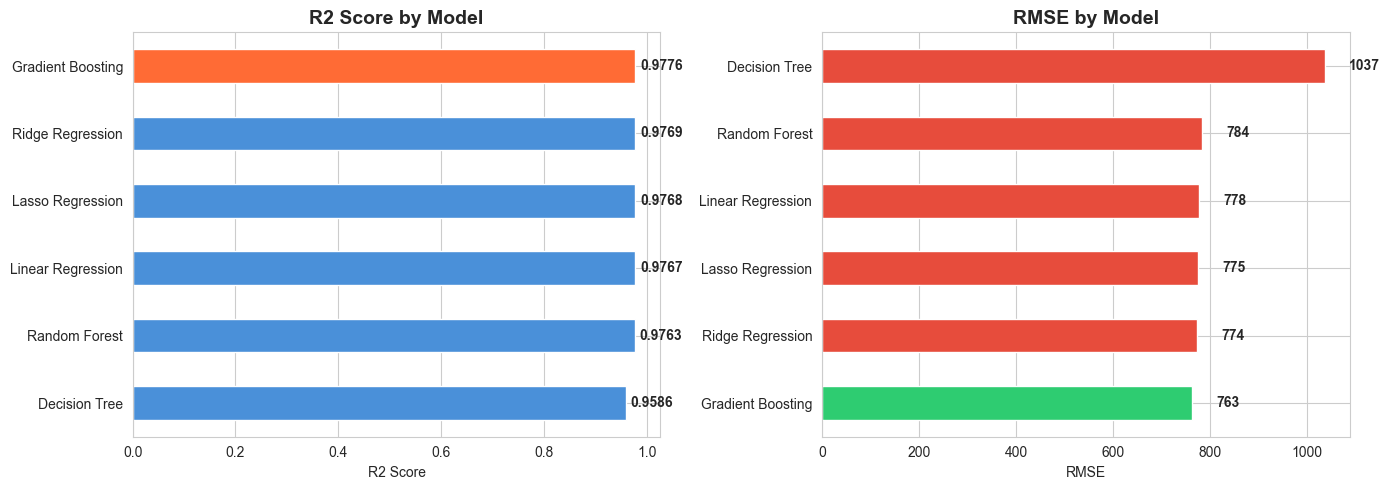

In [32]:
# 모델 성능 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R2 Score
r2_sorted = results_df['R2'].sort_values()
colors_r2 = ['#ff6b35' if v == r2_sorted.max() else '#4a90d9' for v in r2_sorted.values]
r2_sorted.plot(kind='barh', ax=axes[0], color=colors_r2, edgecolor='white')
axes[0].set_title('R2 Score by Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('R2 Score')
for i, (idx, val) in enumerate(r2_sorted.items()):
    axes[0].text(val + 0.01, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

# RMSE
rmse_sorted = results_df['RMSE'].sort_values()
colors_rmse = ['#2ecc71' if v == rmse_sorted.min() else '#e74c3c' for v in rmse_sorted.values]
rmse_sorted.plot(kind='barh', ax=axes[1], color=colors_rmse, edgecolor='white')
axes[1].set_title('RMSE by Model', fontsize=14, fontweight='bold')
axes[1].set_xlabel('RMSE')
for i, (idx, val) in enumerate(rmse_sorted.items()):
    axes[1].text(val + 50, i, f'{val:.0f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
save_fig('13_model_comparison.png')
plt.show()

## 6. 하이퍼파라미터 튜닝

In [33]:
# Random Forest 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_model, rf_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"\nRandom Forest 최적 파라미터: {grid_search_rf.best_params_}")
print(f"Random Forest 최고 R2 Score: {grid_search_rf.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Random Forest 최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest 최고 R2 Score: 0.9734


In [34]:
# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(gb_model, gb_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_scaled, y_train)

print(f"\nGradient Boosting 최적 파라미터: {grid_search_gb.best_params_}")
print(f"Gradient Boosting 최고 R2 Score: {grid_search_gb.best_score_:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Gradient Boosting 최적 파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
Gradient Boosting 최고 R2 Score: 0.9723


In [35]:
# 최적화된 모델로 최종 평가
best_rf = grid_search_rf.best_estimator_
best_gb = grid_search_gb.best_estimator_

# Random Forest 예측
y_pred_rf = best_rf.predict(X_test_scaled)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Gradient Boosting 예측
y_pred_gb = best_gb.predict(X_test_scaled)
gb_r2 = r2_score(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print("=" * 50)
print("최적화된 모델 성능")
print("=" * 50)
print(f"Random Forest - R2: {rf_r2:.4f}, RMSE: {rf_rmse:.2f}")
print(f"Gradient Boosting - R2: {gb_r2:.4f}, RMSE: {gb_rmse:.2f}")

최적화된 모델 성능
Random Forest - R2: 0.9768, RMSE: 776.66
Gradient Boosting - R2: 0.9788, RMSE: 742.50


저장 완료: images/14_actual_vs_predicted.png


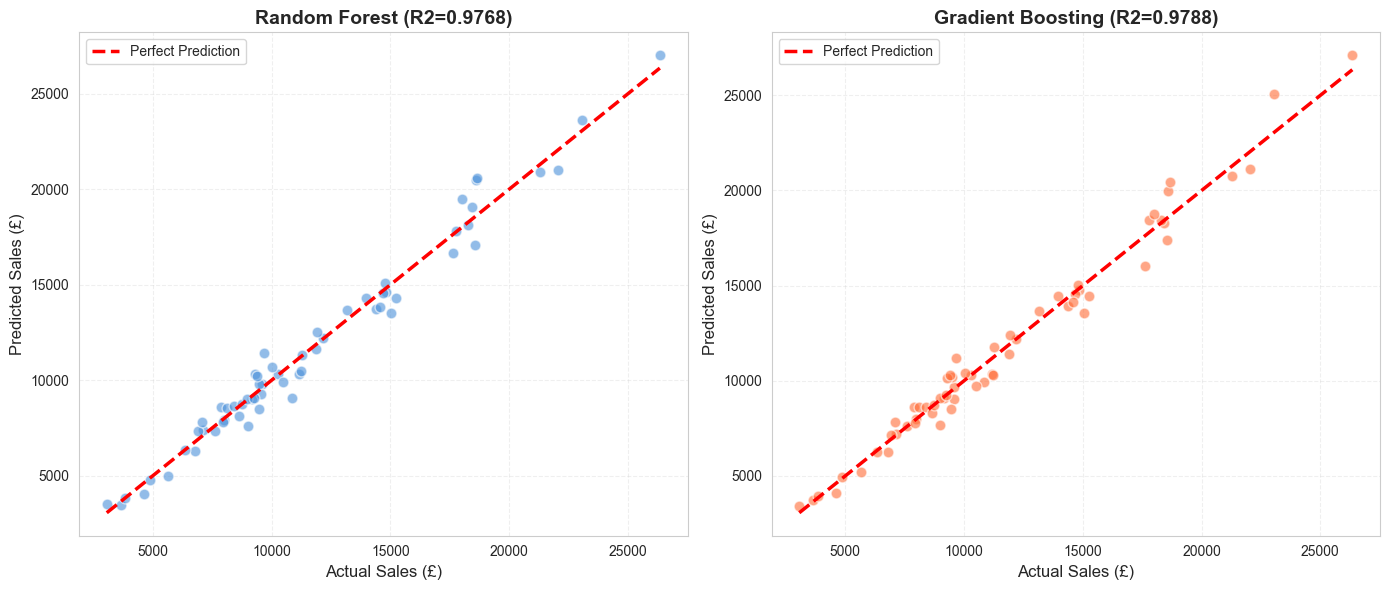

In [36]:
# 예측 vs 실제 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_test, y_pred_rf, alpha=0.6, color='#4a90d9', s=60, edgecolor='white')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2.5, label='Perfect Prediction')
axes[0].set_xlabel('Actual Sales (£)', fontsize=12)
axes[0].set_ylabel('Predicted Sales (£)', fontsize=12)
axes[0].set_title(f'Random Forest (R2={rf_r2:.4f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, linestyle='--')

# Gradient Boosting
axes[1].scatter(y_test, y_pred_gb, alpha=0.6, color='#ff6b35', s=60, edgecolor='white')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2.5, label='Perfect Prediction')
axes[1].set_xlabel('Actual Sales (£)', fontsize=12)
axes[1].set_ylabel('Predicted Sales (£)', fontsize=12)
axes[1].set_title(f'Gradient Boosting (R2={gb_r2:.4f})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
save_fig('14_actual_vs_predicted.png')
plt.show()

저장 완료: images/15_feature_importance.png


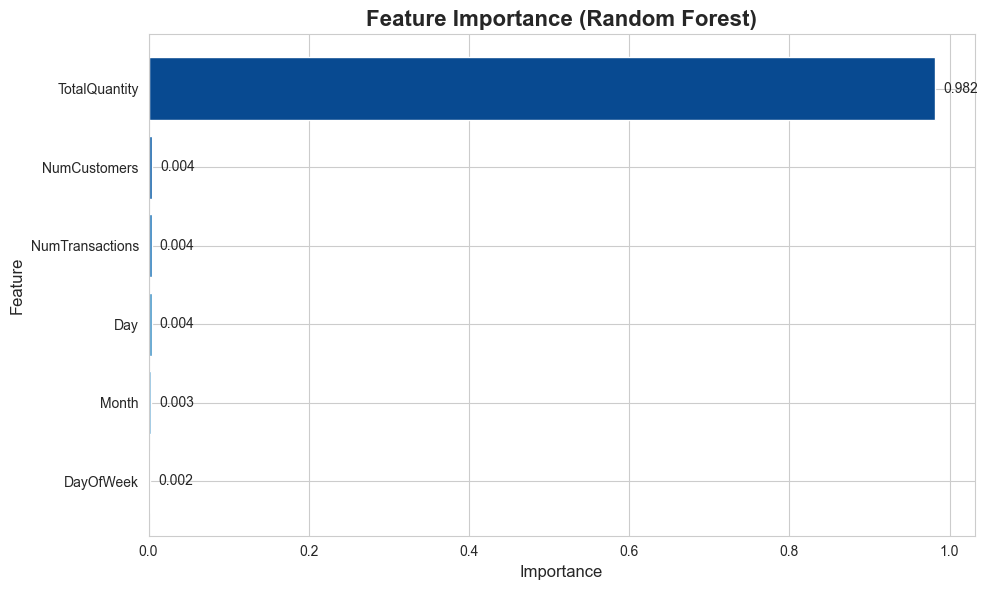


특성 중요도:


,Feature,Importance
0,TotalQuantity,0.982123
2,NumCustomers,0.004385
1,NumTransactions,0.004077
5,Day,0.003797
4,Month,0.003400
3,DayOfWeek,0.002218


In [37]:
# 특성 중요도 (Random Forest)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(feature_importance)))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors, edgecolor='white')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance (Random Forest)', fontsize=16, fontweight='bold')

for bar, val in zip(bars, feature_importance['Importance'].values):
    plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
save_fig('15_feature_importance.png')
plt.show()

print("\n특성 중요도:")
feature_importance.sort_values('Importance', ascending=False)